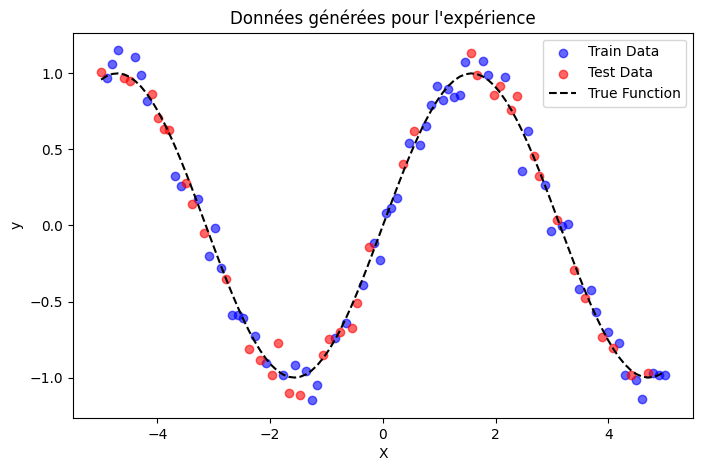

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Fixer un seed pour la reproductibilité
np.random.seed(42)

# Génération des points x
n_samples = 100
X = np.linspace(-5, 5, n_samples).reshape(-1, 1)

# Génération des cibles y avec du bruit gaussien
def true_function(x):
    return np.sin(x)

noise_std = 0.1  # Écart-type du bruit
y = true_function(X) + np.random.normal(0, noise_std, X.shape)

# Division en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Affichage des données
def plot_data():
    plt.figure(figsize=(8, 5))
    plt.scatter(X_train, y_train, label='Train Data', color='blue', alpha=0.6)
    plt.scatter(X_test, y_test, label='Test Data', color='red', alpha=0.6)
    plt.plot(X, true_function(X), label='True Function', color='black', linestyle='dashed')
    plt.legend()
    plt.title("Données générées pour l'expérience")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.show()

plot_data()


In [5]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Normalisation des données
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Définition du modèle GP dans PyMC
def build_gp_model(X, y, use_cml=False, m=30):
    with pm.Model() as model:
        length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
        variance = pm.Gamma("variance", alpha=2, beta=1)
        
        cov_func = variance * pm.gp.cov.ExpQuad(input_dim=1, ls=length_scale)
        gp = pm.gp.Marginal(cov_func=cov_func)
        
        if use_cml:
            # On conditionne uniquement sur les m premiers points
            X_cond, y_cond = X[:m], y[:m]
        else:
            X_cond, y_cond = X, y  # Utilise toutes les données
        
        noise = pm.HalfNormal("noise", sigma=0.1)
        y_obs = gp.marginal_likelihood("y_obs", X=X_cond, y=y_cond, noise=noise)
        
    return model

# Optimisation des hyperparamètres avec ML
ml_model = build_gp_model(X_train_scaled, y_train_scaled, use_cml=False)
with ml_model:
    ml_trace = pm.find_MAP()
    print("Hyperparamètres appris avec ML:", ml_trace)

# Optimisation des hyperparamètres avec CML (30 premiers points)
cml_model = build_gp_model(X_train_scaled, y_train_scaled, use_cml=True, m=30)
with cml_model:
    cml_trace = pm.find_MAP()
    print("Hyperparamètres appris avec CML:", cml_trace)

# Comparaison des hyperparamètres appris
print("\nComparaison des hyperparamètres ML vs CML:")
print("ML:", ml_trace)
print("CML:", cml_trace)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

Hyperparamètres appris avec ML: {'length_scale_log__': array(-0.37881034), 'variance_log__': array(0.49373568), 'noise_log__': array(-2.00891532), 'length_scale': array(0.68467546), 'variance': array(1.63842544), 'noise': array(0.13413409)}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

Hyperparamètres appris avec CML: {'length_scale_log__': array(-0.37917854), 'variance_log__': array(0.56361095), 'noise_log__': array(-2.19554093), 'length_scale': array(0.6844234), 'variance': array(1.75700552), 'noise': array(0.11129834)}

Comparaison des hyperparamètres ML vs CML:
ML: {'length_scale_log__': array(-0.37881034), 'variance_log__': array(0.49373568), 'noise_log__': array(-2.00891532), 'length_scale': array(0.68467546), 'variance': array(1.63842544), 'noise': array(0.13413409)}
CML: {'length_scale_log__': array(-0.37917854), 'variance_log__': array(0.56361095), 'noise_log__': array(-2.19554093), 'length_scale': array(0.6844234), 'variance': array(1.75700552), 'noise': array(0.11129834)}


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

Hyperparamètres ML (Mean Constant): {'length_scale_log__': array(-1.37581332), 'variance_log__': array(-0.05691915), 'noise_log__': array(-1.84867336), 'mean': array(0.08216447), 'length_scale': array(0.25263404), 'variance': array(0.94467044), 'noise': array(0.1574459)}


Output()

Hyperparamètres ML (Mean MLP): {'length_scale_log__': array(-1.37933072), 'variance_log__': array(-0.0796893), 'noise_log__': array(-1.84878858), 'mlp_weights': array([-0.16846022]), 'length_scale': array(0.25174699), 'variance': array(0.9234032), 'noise': array(0.15742776)}


/var/folders/wz/v08qkf7d7rv2h5965ntwkg8m0000gn/T/ipykernel_57700/1858505986.py:78: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


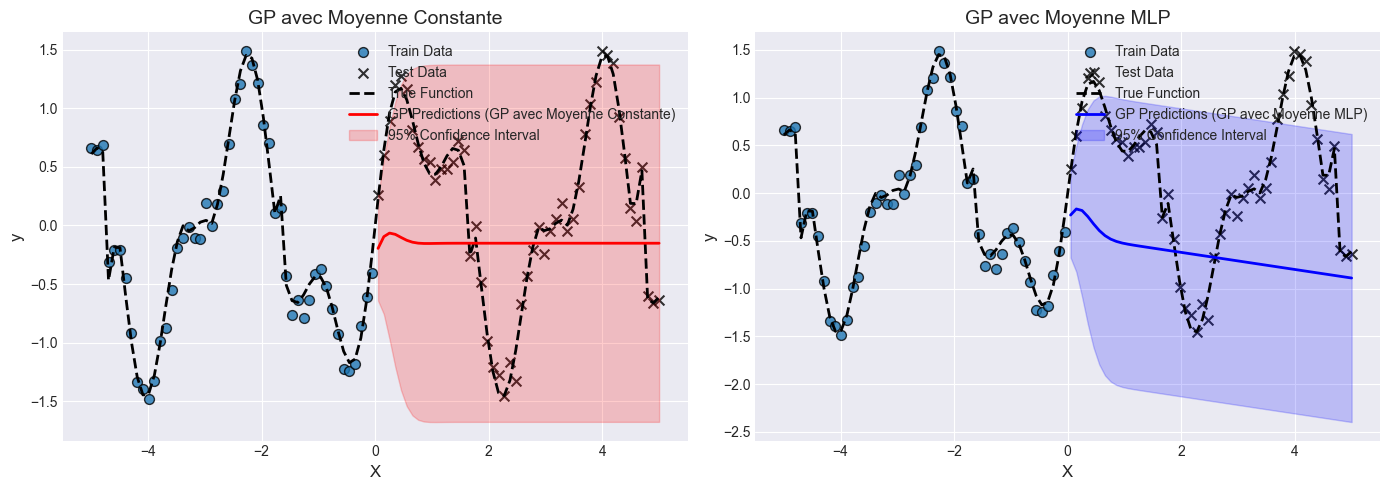

In [26]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Génération de données synthétiques
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y_true = np.sign(np.sin(2 * X)) * np.abs(np.sin(2 * X) + 0.5 * np.sin(5 * X))
y = y_true + 0.1 * np.random.randn(*y_true.shape)

# Division des données : premiers 80% pour train, derniers 20% pour test
split_index = int(0.5 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Normalisation des données
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Fonction pour créer un modèle GP avec un prior moyen constant ou un MLP
def build_gp_model(X, y, use_mlp_mean=False):
    with pm.Model() as model:
        length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
        variance = pm.Gamma("variance", alpha=2, beta=1)
        noise = pm.HalfNormal("noise", sigma=0.05)
        
        cov_func = variance * pm.gp.cov.ExpQuad(input_dim=1, ls=length_scale)
        
        if use_mlp_mean:
            mean_func = pm.gp.mean.Linear(coeffs=pm.Normal("mlp_weights", mu=0, sigma=1, shape=(1,)))
        else:
            mean_func = pm.gp.mean.Constant(pm.Normal("mean", mu=0, sigma=1))
        
        gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
        
        y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=noise)
        model.gp = gp
    
    return model

# Création des modèles GP
constant_mean_model = build_gp_model(X_train_scaled, y_train_scaled, use_mlp_mean=False)
mlp_mean_model = build_gp_model(X_train_scaled, y_train_scaled, use_mlp_mean=True)

# Optimisation via ML
with constant_mean_model:
    constant_mean_trace = pm.find_MAP()
    print("Hyperparamètres ML (Mean Constant):", constant_mean_trace)

with mlp_mean_model:
    mlp_mean_trace = pm.find_MAP()
    print("Hyperparamètres ML (Mean MLP):", mlp_mean_trace)

# Fonction pour générer des prédictions
def gp_predict(model, X_test, trace):
    with model:
        mu, var = model.gp.predict(X_test, point=trace, diag=True, pred_noise=True)
        std = np.sqrt(var)
    return mu, std

# Prédictions
mu_constant, std_constant = gp_predict(constant_mean_model, X_test_scaled, constant_mean_trace)
mu_mlp, std_mlp = gp_predict(mlp_mean_model, X_test_scaled, mlp_mean_trace)

# Re-normalisation
y_pred_constant = scaler_y.inverse_transform(mu_constant.reshape(-1, 1)).ravel()
y_std_constant = std_constant * scaler_y.scale_
y_pred_mlp = scaler_y.inverse_transform(mu_mlp.reshape(-1, 1)).ravel()
y_std_mlp = std_mlp * scaler_y.scale_

# Affichage des résultats
def plot_gp_results(y_pred_constant, y_std_constant, y_pred_mlp, y_std_mlp):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plt.style.use('seaborn-darkgrid')
    
    titles = ["GP avec Moyenne Constante", "GP avec Moyenne MLP"]
    preds = [(y_pred_constant, y_std_constant), (y_pred_mlp, y_std_mlp)]
    colors = ["red", "blue"]
    
    for i, ax in enumerate(axes):
        y_pred, y_std = preds[i]
        color = colors[i]
        
        ax.scatter(X_train, y_train, label='Train Data', edgecolors='black', s=50, alpha=0.8)
        ax.scatter(X_test, y_test, label='Test Data', color='black', marker='x', s=50, alpha=0.8)
        ax.plot(X, y_true, label='True Function', color='black', linestyle='dashed', linewidth=2)
        ax.plot(X_test, y_pred, label=f'GP Predictions ({titles[i]})', color=color, linestyle='solid', linewidth=2)
        ax.fill_between(X_test.ravel(), y_pred - 2 * y_std, y_pred + 2 * y_std, 
                        alpha=0.2, color=color, label='95% Confidence Interval')
        
        ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel("X", fontsize=12)
        ax.set_ylabel("y", fontsize=12)
        ax.legend(fontsize=10, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Affichage final
plot_gp_results(y_pred_constant, y_std_constant, y_pred_mlp, y_std_mlp)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pymc/gp/gp.py:55: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


Output()

Hyperparamètres ML (Mean Constant): {'length_scale_log__': array(-1.37581332), 'variance_log__': array(-0.05691915), 'noise_log__': array(-1.84867336), 'mean': array(0.08216447), 'length_scale': array(0.25263404), 'variance': array(0.94467044), 'noise': array(0.1574459)}


Output()

Hyperparamètres ML (Mean MLP): {'length_scale_log__': array(-1.37933072), 'variance_log__': array(-0.0796893), 'noise_log__': array(-1.84878858), 'mlp_weights': array([-0.16846022]), 'length_scale': array(0.25174699), 'variance': array(0.9234032), 'noise': array(0.15742776)}


/var/folders/wz/v08qkf7d7rv2h5965ntwkg8m0000gn/T/ipykernel_57700/1235175588.py:79: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


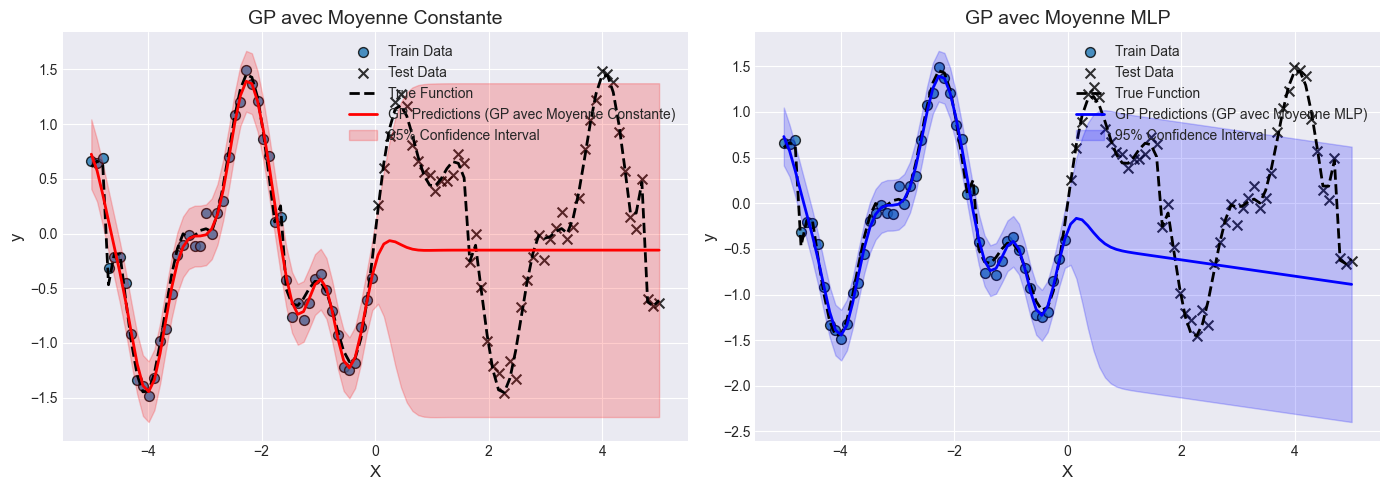

In [27]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Génération de données synthétiques
np.random.seed(42)
X = np.linspace(-5, 5, 100).reshape(-1, 1)
y_true = np.sign(np.sin(2 * X)) * np.abs(np.sin(2 * X) + 0.5 * np.sin(5 * X))
y = y_true + 0.1 * np.random.randn(*y_true.shape)

# Division des données : premiers 80% pour train, derniers 20% pour test
split_index = int(0.5 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Normalisation des données
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_full_scaled = scaler_X.transform(X)  # Échelle complète pour tout suivre
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).ravel()

# Fonction pour créer un modèle GP avec un prior moyen constant ou un MLP
def build_gp_model(X, y, use_mlp_mean=False):
    with pm.Model() as model:
        length_scale = pm.Gamma("length_scale", alpha=2, beta=1)
        variance = pm.Gamma("variance", alpha=2, beta=1)
        noise = pm.HalfNormal("noise", sigma=0.05)
        
        cov_func = variance * pm.gp.cov.ExpQuad(input_dim=1, ls=length_scale)
        
        if use_mlp_mean:
            mean_func = pm.gp.mean.Linear(coeffs=pm.Normal("mlp_weights", mu=0, sigma=1, shape=(1,)))
        else:
            mean_func = pm.gp.mean.Constant(pm.Normal("mean", mu=0, sigma=1))
        
        gp = pm.gp.Marginal(mean_func=mean_func, cov_func=cov_func)
        
        y_obs = gp.marginal_likelihood("y_obs", X=X, y=y, noise=noise)
        model.gp = gp
    
    return model

# Création des modèles GP
constant_mean_model = build_gp_model(X_train_scaled, y_train_scaled, use_mlp_mean=False)
mlp_mean_model = build_gp_model(X_train_scaled, y_train_scaled, use_mlp_mean=True)

# Optimisation via ML
with constant_mean_model:
    constant_mean_trace = pm.find_MAP()
    print("Hyperparamètres ML (Mean Constant):", constant_mean_trace)

with mlp_mean_model:
    mlp_mean_trace = pm.find_MAP()
    print("Hyperparamètres ML (Mean MLP):", mlp_mean_trace)

# Fonction pour générer des prédictions sur toute la plage
def gp_predict(model, X_full, trace):
    with model:
        mu, var = model.gp.predict(X_full, point=trace, diag=True, pred_noise=True)
        std = np.sqrt(var)
    return mu, std

# Prédictions sur tout X
mu_constant, std_constant = gp_predict(constant_mean_model, X_full_scaled, constant_mean_trace)
mu_mlp, std_mlp = gp_predict(mlp_mean_model, X_full_scaled, mlp_mean_trace)

# Re-normalisation
y_pred_constant = scaler_y.inverse_transform(mu_constant.reshape(-1, 1)).ravel()
y_std_constant = std_constant * scaler_y.scale_
y_pred_mlp = scaler_y.inverse_transform(mu_mlp.reshape(-1, 1)).ravel()
y_std_mlp = std_mlp * scaler_y.scale_

# Affichage des résultats avec toute la plage
def plot_gp_results(y_pred_constant, y_std_constant, y_pred_mlp, y_std_mlp):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    plt.style.use('seaborn-darkgrid')
    
    titles = ["GP avec Moyenne Constante", "GP avec Moyenne MLP"]
    preds = [(y_pred_constant, y_std_constant), (y_pred_mlp, y_std_mlp)]
    colors = ["red", "blue"]
    
    for i, ax in enumerate(axes):
        y_pred, y_std = preds[i]
        color = colors[i]
        
        ax.scatter(X_train, y_train, label='Train Data', edgecolors='black', s=50, alpha=0.8)
        ax.scatter(X_test, y_test, label='Test Data', color='black', marker='x', s=50, alpha=0.8)
        ax.plot(X, y_true, label='True Function', color='black', linestyle='dashed', linewidth=2)
        ax.plot(X, y_pred, label=f'GP Predictions ({titles[i]})', color=color, linestyle='solid', linewidth=2)
        ax.fill_between(X.ravel(), y_pred - 2 * y_std, y_pred + 2 * y_std, 
                        alpha=0.2, color=color, label='95% Confidence Interval')
        
        ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel("X", fontsize=12)
        ax.set_ylabel("y", fontsize=12)
        ax.legend(fontsize=10, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Affichage final sur toute la plage de X
plot_gp_results(y_pred_constant, y_std_constant, y_pred_mlp, y_std_mlp)